# Select frequency-range for Fourier transform in CSEM modelling



## Note
- Depending on the signal the real or imaginary part is used:
  - `signal >= 0`: Sine transform, imaginary part is used,
  - `signal < 0`: Cosine transform, real part is used.
- The 1D-model is for an inline-survey:
  - `src = [0, 0, src_z]` (at the origin at a given depth),
  - `rec = [off, 0, rec_z]` (in-line receiver at a given offset and depth).

In [1]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt

### `frequency-selection`

The frequency-selection GUI has its own repo with more examples.
Check-out: https://github.com/empymod/frequency-selection
The relevant part for this publication is copied here into `freqselect.py` in this directory.

In [2]:
import freqselect  # Script in this directory

In [3]:
%matplotlib notebook

In [4]:
#%%html
#<style>
#  .output_wrapper .ui-dialog-titlebar {display: none;}
#  .container { width:100% !important; }
#</style>

## Model

In [5]:
time = np.logspace(-2, 3, 301)  # Times; select a wide range.
src_z = 950                     # Source depth.
rec_z = 1000                    # Receiver depth.
depth = [0, 1000, 2000, 2100]   # Interfaces (m).
res = [2e14, 0.3, 1, 100, 1]    # Resistivities (Ohm.m).

rec = [np.array([1.5, 3, 6, 12])*1e3, np.zeros(4), rec_z]

# Collect it in a dict.
model = {
    'src': [0, 0, src_z],
    'rec': rec,
    'depth': depth,
    'res': res,
}

## Interactive frequency-selection

<IPython.core.display.Javascript object>


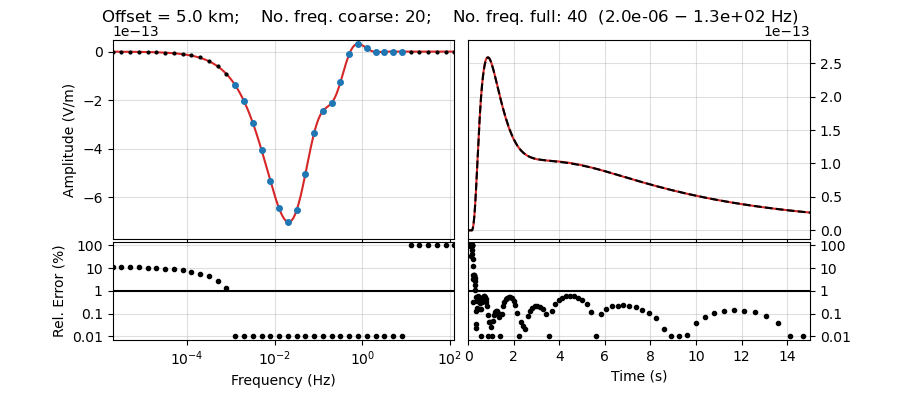

In [6]:
GUI1 = freqselect.InteractiveFrequency(
    src_z=src_z,
    rec_z=rec_z,
    depth=depth,
    res=res,
    time=time,
    ft='fftlog',
    xtfact=3,
    linlog='log',
)
#plt.savefig('../figures/GUI-FFTLog-log.pdf', bbox_inches='tight')

In [7]:
GUI2 = freqselect.InteractiveFrequency(
    src_z=src_z,
    rec_z=rec_z,
    depth=depth,
    res=res,
    time=time,
    ft='dlf',
    ftarg={'dlf': 'key_81_CosSin_2009'},
    xtfact=3,
    linlog='linear',
)
#plt.savefig('../figures/GUI-DLF-lin.pdf', bbox_inches='tight')

In [8]:
GUI = freqselect.InteractiveFrequency(
    src_z=src_z,
    rec_z=rec_z,
    depth=depth,
    res=res,
    time=time,
    ft='fftlog',
    xtfact=3,
)

## Create a `Fourier` instance using the above parameters

In [9]:
Fourier = emg3d.utils.Fourier(
    time=GUI.time,      # Current times from the GUI.
    fmin=GUI.fmin,      # Current fmin from the GUI.
    fmax=GUI.fmax,      # Current fmax from the GUI.
    signal=GUI.signal,  # Current signal from the GUI.
    ft=GUI.ft,          # Current Fourier transform from the GUI.
    ftarg=GUI.ftarg,    # Current FT arguments from the GUI.
)

   time        [s] :  0.01 - 1000 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  2.00364E-06 - 126.421 : 40  [min-max; #]
   Calc. freq [Hz] :  0.00126421 - 7.97664 : 20  [min-max; #]


### Calculate $f-$ and $t-$domain responses

In [10]:
freq_dense = np.logspace(np.log10(Fourier.freq_req.min()/2), np.log10(Fourier.freq_req.max()*2), 301)
fdata_dense = empymod.dipole(freqtime=freq_dense, **model)
fdata_comp = empymod.dipole(freqtime=Fourier.freq_req, **model)
fdata_calc = empymod.dipole(freqtime=Fourier.freq_calc, **model)                    # What we could model in 3D.
tdata_comp = empymod.dipole(freqtime=Fourier.time, signal=Fourier.signal, **model)  # For comparison reasons.


:: empymod END; runtime = 0:00:00.434145 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.051733 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.029607 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.406783 :: 1 kernel call(s)



### Fourier transform

**Note:** The `fdata_req`-step is not necessary, that happens internally when calling `freq2time`. We just do it so we can plot the result.

In [11]:
# Pre-allocate arrays.
fdata_req = np.zeros((Fourier.freq_req.size, rec[0].size), dtype=complex)
tdata = np.zeros((Fourier.time.size, rec[0].size))

# Loop over offsets.
for i, off in enumerate(rec[0]):
    fdata_req[:, i] = Fourier.interpolate(fdata_calc[:, i])
    tdata[:, i] = Fourier.freq2time(fdata_calc[:, i], off)
    
fd_err = np.clip(100*abs((fdata_req-fdata_comp)/fdata_comp), 0.01, 100)
td_err = np.clip(100*abs((tdata-tdata_comp)/tdata_comp), 0.01, 100)

## Plot it

<IPython.core.display.Javascript object>


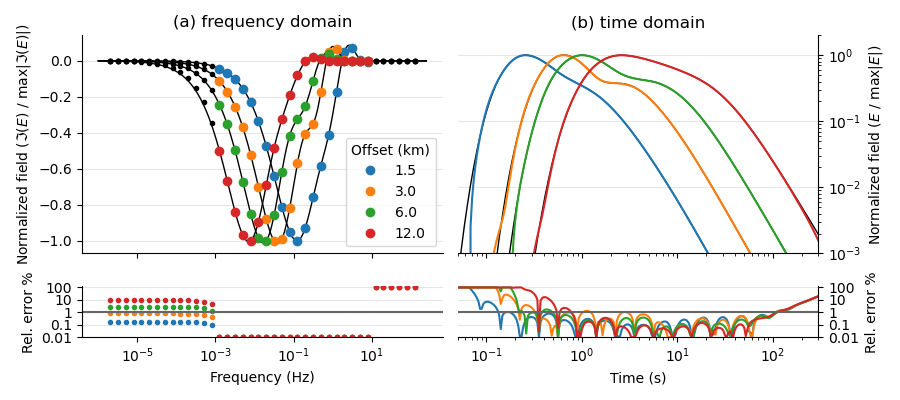

In [12]:
plt.figure(figsize=(9, 4))

# f-domain
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=3)
plt.title('(a) frequency domain')

for i, off in enumerate(rec[0]):
    norm = max(abs(fdata_req[:, i].imag))  # Normalize by max
    plt.plot(freq_dense, fdata_dense[:, i].imag/norm, f'k-', lw=1)
    plt.plot(Fourier.freq_req[~Fourier.freq_calc_i], fdata_req[~Fourier.freq_calc_i, i].imag/norm, 'k.')
    plt.plot(Fourier.freq_calc, fdata_calc[:, i].imag/norm, f'C{i}o', label=off/1e3)

plt.ylabel('Normalized field ($\Im(E)\ /\ \mathrm{max}|\Im(E)|$)')
plt.xscale('log')
plt.legend(title='Offset (km)', loc=4)
plt.grid(axis='y', c='0.9')
ax1.set_xticklabels([])

# f-domain error
ax2 = plt.subplot2grid((4, 2), (3, 0))

plt.plot(Fourier.freq_req, fd_err, '.')
#plt.plot(Fourier.freq_req[~Fourier.freq_calc_i], err[~Fourier.freq_calc_i, ii], 'k.')
#plt.plot(Fourier.freq_calc, err[Fourier.freq_calc_i, ii], 'C0.')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Rel. error %')
plt.xlim(ax1.get_xlim())
plt.ylim([8e-2, 120])
plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
plt.grid(axis='y', c='0.9')

# t-domain
ax3 = plt.subplot2grid((4, 2), (0, 1), rowspan=3)
plt.title('(b) time domain')

for i, off in enumerate(rec[0]):
    norm = max(tdata[:, i])
    plt.plot(time, tdata_comp[:, i]/norm, 'k', lw=1)
    plt.plot(time, tdata[:, i]/norm, '-', label=off/1e3)

plt.ylabel('Normalized field ($E\ / \ \mathrm{max}|E|$)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([.05, 300])
plt.ylim([1e-3, 2e0])
#plt.legend(title='Offset (km)', ncol=2)
plt.grid(axis='y', c='0.9')

ax3.yaxis.set_ticks_position('right')
ax3.yaxis.set_label_position('right')
ax3.set_xticklabels([])

# t-domain error
ax4 = plt.subplot2grid((4, 2), (3, 1))

plt.plot(time, td_err, '-')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.xlim(ax3.get_xlim())
plt.ylim([8e-2, 120])
plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')

# Switch off spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)

plt.tight_layout()
#plt.savefig('../figures/multi-offset.pdf', bbox_inches='tight')
plt.show()

In [13]:
emg3d.Report(empymod)

--------------------------------------------------------------------------------
  Date: Tue Jun 30 17:34:36 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00)
  [GCC 7.5.0]

           empymod : 2.0.1
             numpy : 1.18.5
             scipy : 1.4.1
             numba : 0.48.0
             emg3d : 0.11.0
           IPython : 7.15.0
        matplotlib : 3.2.2
--------------------------------------------------------------------------------